# Westeros Tutorial Water



## Ready, steady, go!

First, we import all the packages we need. We import a utility function called *make_df*, which can be used to wrap the input data into dataframes that can be saved in model parameters.

In [1]:
import pandas as pd
import ixmp
import message_ix

from message_ix.utils import make_df

%matplotlib inline

<IPython.core.display.Javascript object>

The *MESSAGEix* model is built using the *ixmp* `Platform`. The `Platform` is your connection to a database for storing model input data and scenario results.

In [2]:
mp = ixmp.Platform()

Once connected, we create a new `Scenario` to build our model. A `Scenario` instance will contain all the model input data and results.

In [3]:
scenario = message_ix.Scenario(mp, model='Sample Water' ,
                               scenario='baseline', version='new')

Missing annotation for new Scenario Sample Water/baseline
Existing index sets of 'cat_emission' ['type_emission', 'emission'] do not match ('type_emission', 'emission')
Existing index sets of 'cat_node' ['type_node', 'node'] do not match ('type_node', 'node')
Existing index sets of 'cat_relation' ['type_relation', 'relation'] do not match ('type_relation', 'relation')
Existing index sets of 'cat_tec' ['type_tec', 'technology'] do not match ('type_tec', 'technology')
Existing index sets of 'cat_year' ['type_year', 'year'] do not match ('type_year', 'year')
Existing index sets of 'map_shares_commodity_share' ['shares', 'node', 'node', 'type_tec', 'mode', 'commodity', 'level'] do not match ('shares', 'node', 'node', 'type_tec', 'mode', 'commodity', 'level')
Existing index names of 'map_shares_commodity_share' ['shares', 'node_share', 'node', 'type_tec', 'mode', 'commodity', 'level'] do not match ('shares', 'node_share', 'node', 'type_tec', 'mode', 'commodity', 'level')
Existing index sets

Existing index sets of 'fixed_land' ['node', 'land_scenario', 'year'] do not match ('node', 'land_scenario', 'year')
Existing index sets of 'fixed_new_capacity' ['node', 'technology', 'year'] do not match ('node', 'technology', 'year')
Existing index names of 'fixed_new_capacity' ['node_loc', 'technology', 'year_vtg'] do not match ('node_loc', 'technology', 'year_vtg')
Existing index sets of 'fixed_stock' ['node', 'commodity', 'level', 'year'] do not match ('node', 'commodity', 'level', 'year')
Existing index sets of 'flexibility_factor' ['node', 'technology', 'year', 'year', 'mode', 'commodity', 'level', 'time', 'rating'] do not match ('node', 'technology', 'year', 'year', 'mode', 'commodity', 'level', 'time', 'rating')
Existing index names of 'flexibility_factor' ['node_loc', 'technology', 'year_vtg', 'year_act', 'mode', 'commodity', 'level', 'time', 'rating'] do not match ('node_loc', 'technology', 'year_vtg', 'year_act', 'mode', 'commodity', 'level', 'time', 'rating')
Existing inde

Existing index sets of 'output' ['node', 'technology', 'year', 'year', 'mode', 'node', 'commodity', 'level', 'time', 'time'] do not match ('node', 'technology', 'year', 'year', 'mode', 'node', 'commodity', 'level', 'time', 'time')
Existing index names of 'output' ['node_loc', 'technology', 'year_vtg', 'year_act', 'mode', 'node_dest', 'commodity', 'level', 'time', 'time_dest'] do not match ('node_loc', 'technology', 'year_vtg', 'year_act', 'mode', 'node_dest', 'commodity', 'level', 'time', 'time_dest')
Existing index sets of 'peak_load_factor' ['node', 'commodity', 'level', 'year', 'time'] do not match ('node', 'commodity', 'level', 'year', 'time')
Existing index sets of 'rating_bin' ['node', 'technology', 'year', 'commodity', 'level', 'time', 'rating'] do not match ('node', 'technology', 'year', 'commodity', 'level', 'time', 'rating')
Existing index names of 'rating_bin' ['node', 'technology', 'year_act', 'commodity', 'level', 'time', 'rating'] do not match ('node', 'technology', 'year

## Model Structure

We start by defining basic characteristics of the model, including time, space, and the energy system structure.

The model horizon will span 3 decades (690-720). Let's assume that we're far in the future after the events of A Song of Ice and Fire (which occur ~300 years after Aegon the conqueror).

| Math Notation | Model Meaning                |
|---------------|------------------------------|
| $y \in Y^H$   | time periods in history      |
| $y \in Y^M$   | time periods in model horizon|

In [4]:
history = [690]
model_horizon = [700, 710, 720]
scenario.add_horizon(
    year=history + model_horizon,
    firstmodelyear=model_horizon[0]
)

Our model will have a single `node`, i.e., its spatial dimension.


| Math Notation | Model Meaning|
|---------------|--------------|
| $n \in N$     | node         |

In [5]:
region = ('AFR')
basin = ('basin_1', 'basin_2')

scenario.add_spatial_sets({'region': region,
                           'country':basin
                          })

In [6]:
scenario.set('map_node')

,node_parent,node


In [7]:
basin = pd.DataFrame({ "node_parent": ('AFR','AFR','AFR','basin_1', 'basin_2'),
                       "node": ('AFR','basin_1', 'basin_2','basin_1', 'basin_2')})

In [8]:
scenario.add_set("map_node",basin)

In [9]:
scenario.set("map_node")
#shoudl have each region too. 

,node_parent,node
0,AFR,AFR
1,AFR,basin_1
2,AFR,basin_2
3,basin_1,basin_1
4,basin_2,basin_2


In [10]:
scenario.set("node")

0      World
1        AFR
2    basin_1
3    basin_2
dtype: object

And we fill in the energy system's `commodities`, `levels`, `technologies`, and `modes` (i.e., modes of operation of technologies). This information defines how certain technologies operate. 


| Math Notation | Model Meaning|
|---------------|--------------|
| $c \in C$     | commodity    |
| $l \in L$     | level        |
| $t \in T$     | technology   |
| $m \in M$     | mode         |

In [11]:
scenario.add_set("commodity", ["water_source","water_demand","t_d"])
scenario.add_set("level", ["water_supply", "final", "useful"])
scenario.add_set("technology", ['freshwater', 'groundwater', 'water_t_d', 'water_withdrawal'])
scenario.add_set("mode", "standard")

## Supply and Demand (or Balancing Commodities)

The fundamental premise of the model is to satisfy demand for energy (services).
To first order, demand for services like electricity track with economic productivity (GDP).
We define a GDP profile similar to first-world GDP growth from [1900-1930](https://en.wikipedia.org/wiki/List_of_regions_by_past_GDP):

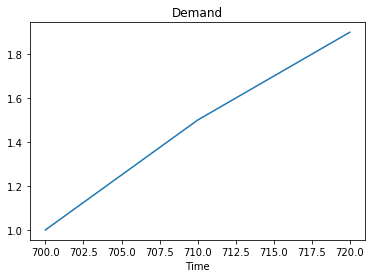

In [12]:
gdp_profile = pd.Series([1., 1.5, 1.9],
                        index=pd.Index(model_horizon, name='Time'))
gdp_profile.plot(title='Demand')

The `COMMODITY_BALANCE_GT` and `COMMODITY_BALANCE_LT` equations ensure that `demand` for each `commodity` is met at each `level` in the energy system.
The equation is copied below in this tutorial notebook, but every model equation is available for reference in
the [Mathematical formulation](https://docs.messageix.org/en/stable/model/MESSAGE/model_core.html) section of the *MESSAGEix* documentation.

$\sum_{\substack{n^L,t,m \\ y^V \leq y}} \text{output}_{n^L,t,y^V,y,m,n,c,l} \cdot \text{ACT}_{n^L,t,y^V,y,m}$
$- \sum_{\substack{n^L,t,m, \\ y^V \leq y}} \text{input}_{n^L,t,y^V,y,m,n,c,l} \cdot \text{ACT}_{n^L,t,m,y}$  
$\geq \text{demand}_{n,c,l,y} \quad \forall \ l \in L$

While `demand` must be met, supply can *exceed* demand allowing the model to plan for meeting demand in future periods by storing storable commodities.


First we establish demand. Let's assume

- 40 million people in [300 AC](https://atlasoficeandfireblog.wordpress.com/2016/03/06/the-population-of-the-seven-kingdoms/)
- similar population growth to Earth in the same time frame [(~factor of 12)](https://en.wikipedia.org/wiki/World_population_estimates)
- a per capita demand for electricity of 1000 kWh
- and 8760 hours in a year (of course!)

Then we can add the demand parameter

Note present day: [~72000 GWh in Austria](https://www.iea.org/statistics/?country=AUSTRIA&year=2016&category=Energy%20consumption&indicator=undefined&mode=chart&dataTable=INDICATORS) with population [~8.7M](http://www.austria.org/population/) which is ~8300 kWh per capita

In [13]:
demand_per_year = 40 * 12 * 1000 / 8760

water_demand = pd.DataFrame({
            'node': 'AFR',
            'commodity': 'water_demand',
            'level': 'useful',
            'year': model_horizon,
            'time': 'year',
            'value': 2*(gdp_profile).round(),
            'unit': 'GWa',
        })

In [14]:
# We use add_par for adding data to a MESSAGEix parameter
scenario.add_par("demand", water_demand)

In [15]:
# water_demand = pd.DataFrame({
#             'node': 'basin_2',
#             'commodity': 'water_demand',
#             'level': 'useful',
#             'year': model_horizon,
#             'time': 'year',
#             'value': ( gdp_profile).round(),
#             'unit': 'GWa',
#         })

In [16]:
# # We use add_par for adding data to a MESSAGEix parameter
# scenario.add_par("demand", water_demand)

In order to define the input and output commodites of each technology, we define some common keys.

- **Input** quantities require `_origin` keys that specify where the inputs are *received from*.
- **Output** quantities require `_dest` keys that specify where the outputs are *transferred to*.

In [17]:
year_df = scenario.vintage_and_active_years()
vintage_years, act_years = year_df['year_vtg'], year_df['year_act']

base = {
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'time': 'year',
    'unit': '-',
}


base_input = make_df(base, time_origin='year')
base_output = make_df(base, time_dest='year')

Working backwards along the Reference Energy System, we can add connections for the `bulb`. A light bulb…

- receives *input* in the form of the "electricity" *commodity* at the "final [energy]" *level*, and
- *outputs* the commodity "light" at the "useful [energy]" level.

The `value` in the input and output parameter is used to represent the effiecieny of a technology (efficiency = output/input).
For example, input of 1.0 and output of 1.0 for a technology shows that the efficiency of that technology is 100% in converting
the input commodity to the output commodity.

In [18]:
df_in = make_df(base_input, technology='freshwater', commodity='water_source',  
                  level='water_supply')

In [19]:
# basin_value = {'basin_1':0.25, 'basin_2':0.55, 'basin_3':0.35, 'basin_4':0.855, 
#         'basin_5':0.52, 'basin_6':0.38, 'basin_7':0.25, 'basin_8':0.75}
basin_value = {'basin_1':75, 'basin_2':45}
for node, val in basin_value.items():
    df_in1 = make_df(df_in,node_loc = node, node_origin=node, value=1)
    scenario.add_par('input', df_in1)

In [20]:
scenario.par('input')

,node_loc,technology,year_vtg,year_act,mode,node_origin,commodity,level,time,time_origin,value,unit
0,basin_1,freshwater,690,700,standard,basin_1,water_source,water_supply,year,year,1.0,-
1,basin_1,freshwater,690,710,standard,basin_1,water_source,water_supply,year,year,1.0,-
2,basin_1,freshwater,690,720,standard,basin_1,water_source,water_supply,year,year,1.0,-
3,basin_1,freshwater,700,700,standard,basin_1,water_source,water_supply,year,year,1.0,-
4,basin_1,freshwater,700,710,standard,basin_1,water_source,water_supply,year,year,1.0,-
5,basin_1,freshwater,700,720,standard,basin_1,water_source,water_supply,year,year,1.0,-
6,basin_1,freshwater,710,710,standard,basin_1,water_source,water_supply,year,year,1.0,-
7,basin_1,freshwater,710,720,standard,basin_1,water_source,water_supply,year,year,1.0,-
8,basin_1,freshwater,720,720,standard,basin_1,water_source,water_supply,year,year,1.0,-
9,basin_2,freshwater,690,700,standard,basin_2,water_source,water_supply,year,year,1.0,-


In [21]:
# basin_value = {'basin_1':1, 'basin_2':1, 'basin_3':1, 'basin_4':1, 
#         'basin_5':1, 'basin_6':1, 'basin_7':1, 'basin_8':1}

df_out = make_df(base_output, technology='water_withdrawal', commodity='water_demand', 
                   level='useful')


for node, val in basin_value.items():
    df_out1 = make_df(df_out,node_loc = node , node_dest=region, value=val)
    scenario.add_par('output', df_out1)


# df_in = make_df(base_input, technology='freshwater', commodity='water_source',  
#                   level='water_supply')
# scenario.add_par('input', df_in)

In [22]:
# scenario.par('output')

In [23]:

df_out = make_df(base_output, technology='water_withdrawal', commodity='water_demand', 
                   level='useful')

basin_value = {'basin_1':75, 'basin_2':45}

for node, val in basin_value.items():
    df_out1 = make_df(df_out,node_loc = node , node_dest=region, value=val)
    scenario.add_par('output', df_out1)

df_in = make_df(base_input, technology='groundwater', commodity='water_source',
                  level='water_supply')

for node, val in basin_value.items():
    df_in1 = make_df(df_in,node_loc = node, node_origin=node, value=1)
    scenario.add_par('input', df_in1)
#scenario.add_par('input', df_in)

In [24]:
df_out = make_df(base_output, technology='water_withdrawal', commodity='water_demand', 
                   level='useful', value=1., unit="GWa")
#scenario.add_par('output', df_out)
basin_value = {'basin_1':23, 'basin_2':45}

for node, val in basin_value.items():
    df_out1 = make_df(df_out, node_loc = node, node_dest=region, value=val)
    scenario.add_par('output', df_out1)


df_in = make_df(base_input, technology='water_t_d', commodity='t_d', 
                   level='final')
#scenario.add_par('output', df_out)
for node, val in basin_value.items():
    df_in1 = make_df(df_in, node_loc =node ,node_origin = node, value = 1)
    scenario.add_par('input', df_in1)

In [25]:
inp = scenario.par('input')
inp.to_csv('input.csv')

## Operational Constraints and Parameters

The model has a number of "reality" constraints, which relate built *capacity* (`CAP`) to available power, or the *activity* (`ACT`) of that technology.

The **capacity constraint** limits the activity of a technology to the installed capacity multiplied by a capacity factor. Capacity factor or is the fraction of installed capacity that can be active in a certain period (here the sub-annual time step *h*).

$$\sum_{m} \text{ACT}_{n,t,y^V,y,m,h}
    \leq \text{duration_time}_{h} \cdot \text{capacity_factor}_{n,t,y^V,y,h} \cdot \text{CAP}_{n,t,y^V,y}
    \quad t \ \in \ T^{INV}$$


This requires us to provide the `capacity_factor` for each technology. Here, we call `make_df()` and `add_par()` in a loop to execute similar code for three technologies:

In [26]:
nodes = ['basin_1','basin_2','AFR']

In [27]:
base_capacity_factor = {
    #'node_loc': region,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'time': 'year',
    'unit': '-',
}

In [28]:
capacity_factor = {
    'freshwater': 0.6,
    'groundwater': 0.3,
    'water_t_d': 0.3, 
}
node = {'basin_1':'basin_1',
       'basin_2': 'basin_2'}
       #'region': 'AFR'}
for tec, val in capacity_factor.items():
    df = make_df(base_capacity_factor, technology=tec, value=val, node_loc = 'basin_1')
    scenario.add_par('capacity_factor', df)
    
for tec, val in capacity_factor.items():
    df = make_df(base_capacity_factor, technology=tec, value=val, node_loc = 'basin_2')
    scenario.add_par('capacity_factor', df)    
    

In [29]:
# scenario.par('capacity_factor')

The model can further be provided `technical_lifetime`s in order to properly manage deployed capacity and related costs via the **capacity maintenance** constraint:

$\text{CAP}_{n,t,y^V,y} \leq \text{remaining_capacity}_{n,t,y^V,y} \cdot \text{value} \quad \forall \quad t \in T^{INV}$

where `value` can take different forms depending on what time period is considered:

| Value                               | Condition                                           |
|-------------------------------------|-----------------------------------------------------|
| $\Delta_y \text{historical_new_capacity}_{n,t,y^V}$ | $y$ is first model period           |
| $\Delta_y \text{CAP_NEW}_{n,t,y^V}$ | $y = y^V$                                           |
| $\text{CAP}_{n,t,y^V,y-1}$          | $0 < y - y^V < \text{technical_lifetime}_{n,t,y^V}$ |


In [30]:
base_technical_lifetime = {
    #'node_loc': region,
    'year_vtg': model_horizon,
    'unit': 'y',
}

In [31]:
lifetime = {
    'freshwater': 10,
    'groundwater': 10,
    'water_t_d': 10, 
}

for tec, val in lifetime.items():
    df = make_df(base_technical_lifetime, technology=tec, value=val,node_loc = 'basin_1')
    scenario.add_par('technical_lifetime', df)
    
for tec, val in lifetime.items():
    df = make_df(base_technical_lifetime, technology=tec, value=val, node_loc = 'basin_2')
    scenario.add_par('technical_lifetime', df)

## Technological Diffusion and Contraction

We know from historical precedent that energy systems can not be transformed instantaneously. Therefore, we use a family of dynamic constraints on activity and capacity. These constraints define the upper and lower limit of the domain of activity and capacity over time based on their value in the previous time step, an initial value, and growth/decline rates.

$\sum_{y^V \leq y,m} \text{ACT}_{n,t,y^V,y,m,h} \leq$  
$\text{initial_activity_up}_{n,t,y,h}
        \cdot \frac{ \Big( 1 + growth\_activity\_up_{n,t,y,h} \Big)^{|y|} - 1 }
                   { growth\_activity\_up_{n,t,y,h} }+ \Big( 1 + growth\_activity\_up_{n,t,y,h} \Big)^{|y|} \cdot \Big( \sum_{y^V \leq y-1,m} ACT_{n,t,y^V,y-1,m,h} + \sum_{m} historical\_activity_{n,t,y-1,m,h}\Big)$  

This example limits the ability for technologies to **grow**. To do so, we  need to provide `growth_activity_up` values for each technology that we want to model as being diffusion constrained. Here, we set this constraint at 10% per year.

In [32]:
base_growth = {
    #'node_loc': region,
    'year_act': model_horizon,
    'time': 'year',
    'unit': '-',
}

In [33]:
growth_technologies = [
    "freshwater", 
    "groundwater", 
]

for tec in growth_technologies:
    df = make_df(base_growth, technology=tec, value=0.1,node_loc = 'basin_1') 
    scenario.add_par('growth_activity_up', df)
    
for tec in growth_technologies:
    df = make_df(base_growth, technology=tec, value=0.1,node_loc = 'basin_2') 
    scenario.add_par('growth_activity_up', df)

## Defining an Energy Mix (Model Calibration)

To model the transition of an energy system, one must start with the existing system which are defined by the parameters `historical_activity` and `historical_new_capacity`. These parameters define the energy mix before the model horizon.  

We begin by defining a few key values:

- how much useful energy was needed
- how much final energy was generated
- and the mix for different technologies

In [34]:
historic_demand = 0.85 * demand_per_year
historic_generation = historic_demand / 1
wat_fraction = 0.6

In [35]:
base_capacity = {
    #'node_loc': region,
    'year_vtg': history,
    'unit': 'GWa',
}

base_activity = {
    #'node_loc': region,
    'year_act': history,
    'mode': 'standard',
    'time': 'year',
    'unit': 'GWa',
}

Then, we can define the **activity** and **capacity** in the historic period

In [36]:
old_activity = {
    'freshwater': wat_fraction * historic_generation,
    'groundwater': (1 - wat_fraction) * historic_generation,
}

for tec, val in old_activity.items():
    df = make_df(base_activity, technology=tec, value=val,node_loc = 'basin_1')
    scenario.add_par('historical_activity', df)
    
for tec, val in old_activity.items():
    df = make_df(base_activity, technology=tec, value=val,node_loc = 'basin_2')
    scenario.add_par('historical_activity', df)

In [37]:
act_to_cap = {
    'freshwater': 1 / 10 / capacity_factor['freshwater'] / 2, # 20 year lifetime
    'groundwater': 1 / 10 / capacity_factor['groundwater'] / 2,
}

for tec in act_to_cap:
    value = old_activity[tec] * act_to_cap[tec]
    df = make_df(base_capacity, technology=tec, value=value,node_loc = 'basin_1')
    scenario.add_par('historical_new_capacity', df)
    
for tec in act_to_cap:
    value = old_activity[tec] * act_to_cap[tec]
    df = make_df(base_capacity, technology=tec, value=value,node_loc = 'basin_2')
    scenario.add_par('historical_new_capacity', df)

## Objective Function

The objective function drives the purpose of the optimization. Do we wish to seek maximum utility of the social planner, minimize carbon emissions, or something else? Classical IAMs seek to minimize total discounted system cost over space and time. 

$$\min \sum_{n,y \in Y^{M}} \text{interestrate}_{y} \cdot \text{COST_NODAL}_{n,y}$$


First, let's add the interest rate parameter.

In [38]:
scenario.add_par("interestrate", model_horizon, value=0.05, unit='-')

`COST_NODAL` is comprised of a variety of costs related to the use of different technologies.

### Investment Costs

Capital, or investment, costs are invoked whenever a new plant or unit is built

$$\text{inv_cost}_{n,t,y} \cdot \text{construction_time_factor}_{n,t,y} \cdot \text{CAP_NEW}_{n,t,y}$$

In [58]:
base_inv_cost = {
    #'node_loc': region,
    'year_vtg': model_horizon,
    'unit': 'USD/kW',
}

# Adding a new unit to the library
mp.add_unit('USD/kW','Km3/year')     

INFO:root:unit `USD/kW` is already defined in the platform instance


In [40]:
# in $ / kW (specific investment cost)
costs = {
    'freshwater': 170,
    'groundwater': 230,
    'water_t_d': 200,
}

for tec, val in costs.items():
    df = make_df(base_inv_cost, technology=tec, value=val,node_loc = 'basin_1')
    scenario.add_par('inv_cost', df)
    
for tec, val in costs.items():
    df = make_df(base_inv_cost, technology=tec, value=val, node_loc = 'basin_2')
    scenario.add_par('inv_cost', df)

### Fixed O&M Costs

Fixed cost are only relevant as long as the capacity is active. This formulation allows to include the potential cost savings from early retirement of installed capacity.

$$\sum_{y^V \leq y} \text{fix_cost}_{n,t,y^V,y} \cdot \text{CAP}_{n,t,y^V,y}$$

In [41]:
base_fix_cost = {
    #'node_loc': region,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'unit': 'USD/kWa',
}

In [42]:
# in $ / kW / year (every year a fixed quantity is destinated to cover part of the O&M costs
# based on the size of the plant, e.g. lightning, labor, scheduled maintenance, etc.)

costs = {
    'freshwater': 30,
    'groundwater': 10,
}

for tec, val in costs.items():
    df = make_df(base_fix_cost, technology=tec, value=val, node_loc = 'basin_1')
    scenario.add_par('fix_cost', df)
    
for tec, val in costs.items():
    df = make_df(base_fix_cost, technology=tec, value=val,node_loc = 'basin_2')
    scenario.add_par('fix_cost', df)

### Variable O&M Costs

Variable Operation and Maintence costs are associated with the costs of actively running the plant. Thus, they are not applied if a plant is on standby (i.e., constructed, but not currently in use).

$$\sum_{\substack{y^V \leq y \\ m,h}} \text{var_cost}_{n,t,y^V,y,m,h} \cdot \text{ACT}_{n,t,y^V,y,m,h} $$

In [43]:
base_var_cost = {
    #'node_loc': region,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'time': 'year',
    'unit': 'USD/kWa',
}

In [44]:
# in $ / kWa (costs associatied to the degradation of equipment when the plant is functioning
# per unit of energy produced kW·year = 8760 kWh.
# Therefore this costs represents USD per 8760 kWh of energy). Do not confuse with fixed O&M units.

costs = {
    'freshwater': 30,
    'groundwater': 50,
}

for tec, val in costs.items():
    df = make_df(base_var_cost, technology=tec, value=val, node_loc = 'basin_1')
    scenario.add_par('var_cost', df)

for tec, val in costs.items():
    df = make_df(base_var_cost, technology=tec, value=val,node_loc = 'basin_2')
    scenario.add_par('var_cost', df)

A full model will also have costs associated with

- costs associated with technologies (investment, fixed, variable costs)
- resource extraction: $\sum_{c,g} \ resource\_cost_{n,c,g,y} \cdot EXT_{n,c,g,y} $
- emissions
- land use (emulator): $\sum_{s} land\_cost_{n,s,y} \cdot LAND_{n,s,y}$

## Time to Solve the Model

First, we *commit* the model structure and input data (sets and parameters).
In the `ixmp` backend, this creates a new model version in the database, which is assigned a version number automatically:

In [45]:
from message_ix import log

log.info('version number prior to commit: {}'.format(scenario.version))

scenario.commit(comment='basic model of Westeros water')

log.info('version number prior committing to the database: {}'.format(scenario.version))

INFO:message_ix:version number prior to commit: 0
INFO:message_ix:version number prior committing to the database: 22


An `ixmp` database can contain many scenarios, and possibly multiple versions of the same model and scenario name.
These are distinguished by unique version numbers.

To make it easier to retrieve the "correct" version (e.g., the latest one), you can set a specific scenario as the default version to use if the "Westeros Electrified" model is loaded from the `ixmp` database.

In [46]:
scenario.set_as_default()

In [47]:
scenario.solve()

In [48]:
scenario.var('OBJ')['lvl']

0.0

## Plotting Results

Analyzing the results of a scenario after it is solved is called **reporting**.
MESSAGE*ix* includes flexible and customizable message_ix/tutorial for reporting, but here we wish to focus on the results of our example scenario.
We use some custom code to set up some simple plots:

In [56]:
# Create a Reporter object to describe and carry out reporting
# calculations and operations (like plotting) based on `scenario`
from message_ix.reporting import Reporter

rep = Reporter.from_scenario(scenario)

# Add keys like "plot activity" to describe reporting operations.
# See tutorial/utils/plotting.py
from message_ix.util.tutorial import prepare_plots

prepare_plots(rep)

Now the object `rep` is ready to generate several plots.

(For a detailed introduction to how the `Reporter` works, see `westeros_report.ipynb`.)

### Activity

How much energy is generated in each time period from the different potential sources?

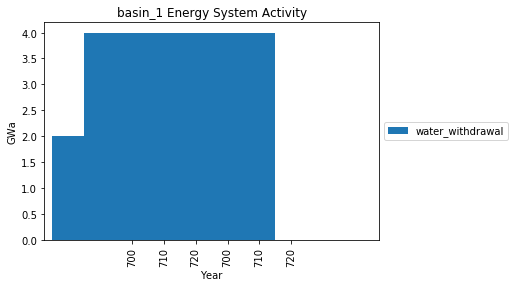

In [57]:
# Only show a subset of technologies in the follow plots;
# e.g. exclude "bulb" and "grid"
#rep.set_filters(t=["groundwater", "freshwater"])

# Trigger the calculation and plotting
rep.get("plot activity")

### Capacity

How much capacity of each plant is installed in each period?

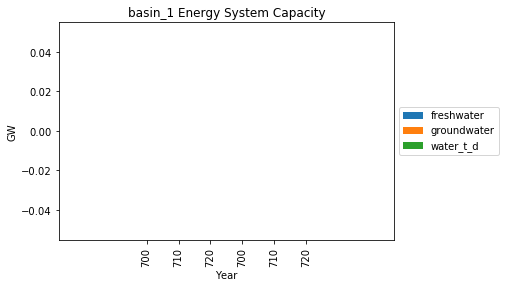

In [51]:
# Create a different plot. The same filters are still active.
rep.get("plot capacity")

In [53]:
# Replace the technology filters with a commodity filter;
# show only "light" and not e.g. "electricity".
rep.set_filters(c=["freshwater"])

# Create a price plot
rep.get("plot prices")

0 values for var 'PRICE_COMMODITY' using filters:
  {'commodity': ['freshwater']}
  Subsequent computations may fail.
  {'commodity': ['freshwater']}
  Subsequent computations may fail.


ComputationError: computing 'plot prices' using:

(functools.partial(<function stacked_bar at 0x1a17e4e4d0>, dims=('n', 'c', 'y'), units='¢/kW·h', title='Energy System Prices', cf=0.01141552511415525, stacked=False), <PRICE_COMMODITY:n-c-y>)

Use Reporter.describe(...) to trace the computation.

Computation traceback:
  File "/Users/MuhammadAwais/Reps/message_ix/message_ix/reporting/computations.py", line 178, in stacked_bar
    title=f"{df.loc[0, dims[0]]} {title}",
  File "/Users/MuhammadAwais/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py", line 873, in __getitem__
    return self._getitem_tuple(key)
  File "/Users/MuhammadAwais/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py", line 1044, in _getitem_tuple
    return self._getitem_lowerdim(tup)
  File "/Users/MuhammadAwais/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py", line 786, in _getitem_lowerdim
    section = self._getitem_axis(key, axis=i)
  File "/Users/MuhammadAwais/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py", line 1110, in _getitem_axis
    return self._get_label(key, axis=axis)
  File "/Users/MuhammadAwais/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py", line 1059, in _get_label
    return self.obj.xs(label, axis=axis)
  File "/Users/MuhammadAwais/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py", line 3491, in xs
    loc = self.index.get_loc(key)
  File "/Users/MuhammadAwais/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/range.py", line 357, in get_loc
    raise KeyError(key) from err
KeyError: 0


## Close the connection to the database

When working with local HSQLDB database instances, you cannot connect to one database from multipe Jupyter notebooks (or processes) at the same time.

If you want to easily switch between notebooks with connections to the same `ixmp` database, you need to close the connection in one notebook before initializing the platform using `ixmp.Platform()` in another notebook.

After having closed the database connection, you can reopen it using
```
mp.open_db()
```

In [ ]:
mp.close_db()

## Congratulations! 

You have built and run your very first *MESSAGEix* model. Welcome to the community!

The next tutorials will introduce you to other features of the framework, including energy system constraints, emissions taxes, and other policy options.

Check us out on Github https://github.com/iiasa/message_ix  
and get in touch with us online https://groups.google.com/forum/message-ix ...